# Hotdog and Not Hotdog Image Classification 

### What you will get from this notebook:

- Read images and process images in Python
- Build your own Hotdog and Not Hotdog application
- Learn VGG (Visual Geometry Group) model

<a href="https://www.youtube.com/watch?v=ACmydtFDTGs">
<img src="./images/hotdogs.png" width="500" >
</a>

### In this notebook, the following python packages will be used:
- **opencv**:      Python API of OpenCV (computer vision library for images)
- **numpy**:    Fundamental package for scientific computing 
- **matplotlib**:    2-D plotting library
- **keras**:    High-level neural networks library, running on top of TensorFlow, CNTK, or Theano
- **scikit-learn(sklearn)**:    Machine learning library in Python

### Install packages
1. `pip install -U pip`    (update your pip)
2. `pip install numpy`
3. `pip install keras`
4. `pip install tensorflow`
5. `pip install opencv-python`
6. `pip install matplotlib`
7. `pip install sklearn`

## Load external libraries

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.contrib.layers import flatten
from keras.utils.np_utils import to_categorical
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers import Conv2D
from keras.layers.pooling import MaxPooling2D
import cv2
import glob

## Read and process  an image:

Common image file format: PNG, JPEG/JPG

Format         | Pros           | Cons     |
--------------------|------------------|-----------------------|
PNG | Lossless compression|Larger file size than JPEG|
JPG/JPEG       | Small file size, widely supported	   | Lossy compression   |


**Pixels and Channels**: 
1. Images are made of pixels, and each pixel is made of primary colors.
2. In a RGB image, each pixel is made of three value(r, g, b) [Demo](https://contrapunctus.net/rgb-demo/)
3. Number of pixels in a image:  ** width \* height **

![egg](./images/channel.jpg)
![egg](./images/cat.jpg)
#### For each channel, it is a matrix of values from 0 to 255


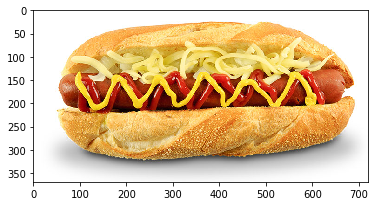

In [43]:
hotdog_image = cv2.imread("images/hotdog.jpg")
plt.imshow(cv2.cvtColor(hotdog_image, cv2.COLOR_RGB2BGR))

In [44]:
height, width, channel = hotdog_image.shape
print ("height(number of rows):", height)
print ("width(number of columns):", width)
print ("channel:", channel)

height(number of rows): 369
width(number of columns): 720
channel: 3


In [45]:
# very top left pixel 
print (hotdog_image[0][0])

# Red channel: Red  
hotdog_image[:, :, 0]

[255 255 255]


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

### Image Smoothing (Image Blurring)
It simply takes the average of all the pixels in the neighboring area and replaces the central element with this average.

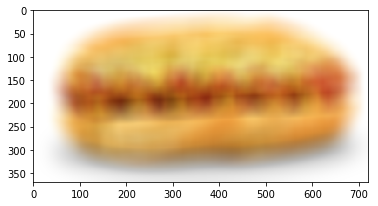

In [58]:
blur = cv2.blur(hotdog_image, (50,50))
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_RGB2BGR))

### Image Rotation

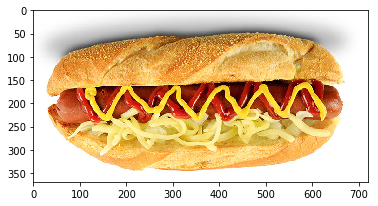

In [47]:
rotate_degree = 180

rotation_matrix = cv2.getRotationMatrix2D((width/2,height/2), rotate_degree, 1)
rotated_images = cv2.warpAffine(hotdog_image, rotation_matrix, (width, height))

plt.imshow(cv2.cvtColor(rotated_images, cv2.COLOR_RGB2BGR))


## Hotdog Classification

**Steps**:
1. Data preparation:
    - Load the images and labels
    - Split the data into two sets:  training set and testing set
2. Build a Convolutional Neural Network model (CNN). 
3. Train the model with the training data and test the accuracy using testing set.

### Step 1:  Load the images and labels

In [48]:
from hotdog import load_images, shuffle_samples

image_size = (128, 128)

# for each image, we will produce one rotated image along with the original image
n_rotated = 1
# number of class, 1 is hotdog, 0 is not hotdog
n_classes = 2

# get all the hotdog and not hotdog images paths
hotdogs = glob.glob('./train_set/hotdog/*.jpg', recursive=True)
not_hotdogs = glob.glob('./train_set/not_hotdog/*.png', recursive=True)

images, label = load_images(hotdogs, not_hotdogs, image_size, n_rotated)

print("There are", len(hotdogs), "hotdog images")
print("There are", len(not_hotdogs), "not hotdog images")



There are 647 hotdog images
There are 787 not hotdog images


In [49]:
# images are all the images combining hotdog and not hotdog images
print (images.shape)


(2868, 128, 128, 3)


####  A sample from the training set  

label: 1


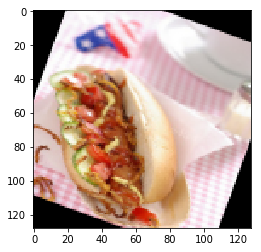

In [50]:
print ("label:", label[23])
plt.imshow(cv2.cvtColor(images[23], cv2.COLOR_RGB2BGR))

label: 0


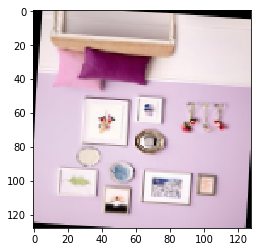

In [51]:
print ("label:", label[2121])
plt.imshow(cv2.cvtColor(images[2121], cv2.COLOR_RGB2BGR))

In [52]:
from hotdog import shuffle_samples
images, labels = shuffle_samples(images, label)

#### Split the dataset  into training and testing set

In [53]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=rand_state)
print("number of training samples", np.array(X_train).shape[0])
print("number of testing samples", np.array(X_test).shape[0])

number of training samples 2581
number of testing samples 287


###  Step 2 : Build the model

In [54]:
def kerasModel(inputShape):
    # feature learning 
    model = Sequential()
    
    # convolutional block 1 
    model.add(Convolution2D(32, (5, 5), input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # convolutional block 2
    model.add(Convolution2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
   
    # convolutional block 3
    model.add(Convolution2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # classification
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile('adam', 'binary_crossentropy', ['accuracy'])
    return model

###  Step 3 : Train and evalutate


In [55]:
inputShape = (128, 128, 3)
model = kerasModel(inputShape)
history = model.fit(X_train, y_train, nb_epoch=10, validation_split=0.1)

metrics = model.evaluate(X_test, y_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))
    


/Users/hhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 2322 samples, validate on 259 samples
Epoch 1/10
2322/2322 [==============================] - 41s 18ms/step - loss: 0.5990 - acc: 0.6904 - val_loss: 0.5509 - val_acc: 0.7683
Epoch 2/10
2322/2322 [==============================] - 44s 19ms/step - loss: 0.5088 - acc: 0.7730 - val_loss: 0.4897 - val_acc: 0.7799
Epoch 3/10
2322/2322 [==============================] - 38s 16ms/step - loss: 0.4670 - acc: 0.7911 - val_loss: 0.6317 - val_acc: 0.7876
Epoch 4/10
2322/2322 [==============================] - 49s 21ms/step - loss: 0.4215 - acc: 0.8247 - val_loss: 0.4249 - val_acc: 0.8224
Epoch 5/10
2322/2322 [==============================] - 45s 19ms/step - loss: 0.3873 - acc: 0.8243 - val_loss: 0.4886 - val_acc: 0.8147
Epoch 6/10
2322/2322 [==============================] - 42s 18ms/step - loss: 0.3526 - acc: 0.8355 - val_loss: 0.4042 - val_acc: 0.8224
Epoch 7/10
2322/2322 [==============================] - 36s 15ms/step - loss: 0.3290 - acc: 0.8506 - val_loss: 0.5437 - val_acc: 0.7954
E

#### Idea of classification:

![dropout](./images/dropout.png)

####  Training Process:
![dropout](./images/classification.gif)


####  Convolutional neural network 
![dropout](./images/cnn.png)

#### How convolutional filter works:

![dropout](./images/conv.gif)
![dropout](./images/stop.png)

# Save the model 

In [56]:
model.save('model.h5') 

### ImageNet Large Scale Visual Recognition Challenge (ILSVRC)

The goal of this image classification challenge is to train a model that can correctly classify **1.2 million** images into 1,000 separate object categories.

These 1,000 image categories represent object classes that we encounter in our day-to-day lives, such as species of dogs, cats, various household objects, vehicle types, and much more. 
## VGG Model 

(Visual Geometry Group from University of Oxford)
![egg](./images/vgg.png)


### Use VGG16 model to convert image to array and compare image similarity

In [57]:
# from keras.applications.vgg16 import VGG16
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.applications.vgg16 import preprocess_input
# from keras.applications.vgg16 import decode_predictions

# model = VGG16()
# model_extractfeatures = Model(input=model.input, output=model.get_layer('fc2').output)

# def convert_image_to_array(image_path):
#     # load an image from file
#     image = load_img(image_path, target_size=(224, 224))
#     # convert the image pixels to a numpy array
#     image_array = img_to_array(image)
#     # add one dimension to the image because VGG model take multiple images as input.
#     image_array = np.expand_dims(image_array, axis=0)
#     # normalize the input
#     processed_array = preprocess_input(image_array)
#     prob = model.predict(processed_array)
#     possible_objects = decode_predictions(prob)
#     fc2_features = model_extractfeatures.predict(processed_array)[0]
#     return possible_objects, fc2_features

# object_hotdog1, hotdog1_fc2_feature = convert_image_to_array("hotdog1.jpeg")
# object_hotdog2, hotdog2_fc2_feature = convert_image_to_array("hotdog2.jpg")
# object_dog, dogs_fc2_feature = convert_image_to_array("dog.jpg")
# object_kobe, kobe_fc2_feature = convert_image_to_array("kobe.jpg")
# dist = np.linalg.norm(hotdog1_fc2_feature - hotdog2_fc2_feature)
# print (dist)
# import scipy
# scipy.spatial.distance.cosine(hotdog1_fc2_feature, hotdog2_fc2_feature)